# Marcos Barragán Corredera

https://www.linkedin.com/in/marcos-barragán-corredera-7415931b7

# Adrián González Retamosa

https://www.linkedin.com/in/adrián-gonzález-retamosa-b283a51b3

## Machine Learning

## CUNEF

### 04/12/2020

## XGBoost Model

In [1]:
import pandas as pd
import xgboost as xgb
import pickle
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.pyplot as pltimport 
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
X_train = pd.read_csv('../data/x_train.csv')
X_test = pd.read_csv('../data/x_test.csv')
Y_train = pd.read_csv('../data/y_train.csv')
Y_test = pd.read_csv('../data/y_test.csv')

Load the Pipeline

In [3]:
pl2 = '../pipelines/tratamiento1.sav'
tratamiento1 = pickle.load(open(pl2, 'rb'))

Building the XGBoost model:

In [4]:
%%time

xgboost_m = Pipeline(steps=[
                           ('preprocesador', tratamiento1),
                           ('clasificador', xgb.XGBClassifier(random_state=1789))])

xgboost_m.fit(X_train, Y_train)

/Users/adrian_gr/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


CPU times: user 2min 5s, sys: 1.21 s, total: 2min 7s
Wall time: 39 s


Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['int_rate', 'annual_inc', 'fico_range_low', 'fico_range_high',
       'pub_rec', 'total_acc', 'last_fico_range_high', 'last_fico_range_low',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_de

The score for both train and test samples is higher than a 90%, which is great.

In [9]:
xgboost_m.score(X_train, Y_train)

0.9091313714520621

In [10]:
xgboost_m.score(X_test, Y_test)

0.9008712082966724

Overfitting is discarded because the accuracy is almost the same for test and train samples. 

As in the other models, we calculate prediction an probability vectors:

In [11]:
Y_pred = xgboost_m.predict(X_test)

In [12]:
Y_prob = xgboost_m.predict_proba(X_test)

Printing the results of XGBoost model for the predicted data, we can notice not only that the accuracy is really high (90%), but also:

+ If we set that somebody is not going to pay, we hit the result 80% of the cases.

+ Moreover, if we establish somebody is going to pay, we hit the 94% of the cases.

We hit 80% of default cases, which is very good for our problem, because we want a precision for defaulters as high as posible.

In [9]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     34886
           1       0.94      0.93      0.93    103772

    accuracy                           0.90    138658
   macro avg       0.87      0.87      0.87    138658
weighted avg       0.90      0.90      0.90    138658



Let's plot out the ROC curve, confusion matrices and cumulative gains curve to see their behaviour over the predicted data.

__ROC curve__

In [22]:
def roc(model, title):
    
    y_pred_prob = model.predict_proba(X_test)
    
    skplt.metrics.plot_roc(Y_test, Y_proba) # un roc con todas las metricas
    plt.title(f"ROCs curve for {title}.");

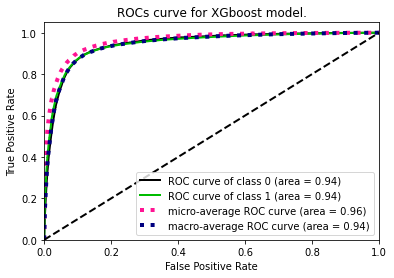

In [11]:
roc(xgboost_m, 'XGboost model')

__Confusion Matrix__

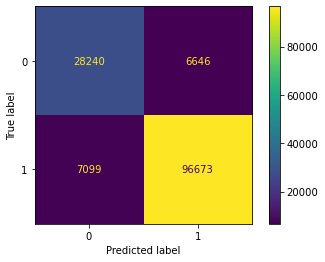

In [12]:
plot_confusion_matrix(xgboost_m, X=X_test, y_true=Y_test);

__Normalized Confusion Matrix__

This matrix returns us that when it is a real 0 we are predicting correctly more than 80%, which is the variable we are interested in.

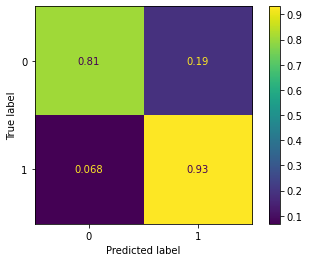

In [13]:
plot_confusion_matrix(xgboost_m, X=X_test, y_true=Y_test, normalize='true');

__Cumulative gains curve__

As well as the other models, it is much more usefull to study the defaulters, because analyzing 20% of the data we will manage to detect more than a 60% of defaults.

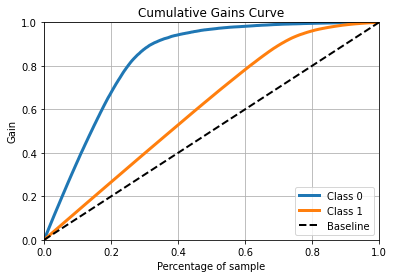

In [15]:
#Vemos que es mucho mas rentable buscar morosos que clientes que pagen, ya que observando el 40% tengo pillo casi al 90% de los morosos y solo al 55% de los que pagan
skplt.metrics.plot_cumulative_gain(Y_test, Y_prob);

We save the model

In [14]:
model = '../modelos/xgboost.sav'
pickle.dump(xgboost_m, open(model, 'wb'))

### Enhancing XGBoost Model

We will develope an update for XGBoost model in prder to see how it could benefit this particular model.

In [9]:
parameters = {
      'clasificador__n_estimator':[200,500],
      'clasificador__max_features':['auto', 'sqrt', 'log2'],
      'clasificador__max_depth':[4,5,8],
      'clasificador__criterion':['gini', 'entropy']
}  

In [10]:
xgboost_opt = RandomizedSearchCV(xgboost_m, parameters, cv=10, random_state=1789, n_jobs=2)

For the train sample:

In [11]:
%%time

xgboost_opt.fit(X_train, Y_train)

/Users/adrian_gr/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[12:09:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { criterion, max_features, n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 1min 50s, sys: 775 ms, total: 1min 51s
Wall time: 46min 4s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocesador',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['int_rate', 'annual_inc', 'fico_range_low', 'fico_range_high',
       'pub_rec', 'total_acc', 'last_fico_range_high', 'last_fico_range_low',
       'acc_now_delinq', 't...
                                                            random_state=1789,
                           

As we see, the parameters that achieve the best model are: 

+ 200 estimators
+ square-root-features evaluation
+ depth number 5
+ best criteria is Gini

In [12]:
print(xgboost_opt.best_params_)
print(xgboost_opt.best_score_)

{'clasificador__n_estimator': 200, 'clasificador__max_features': 'sqrt', 'clasificador__max_depth': 5, 'clasificador__criterion': 'gini'}
0.9002018334936739


In [13]:
xgboost_opt.score(X_train, Y_train)

0.9052028695681739

In [14]:
xgboost_opt.score(X_test, Y_test)

0.9009144802319375

Once we have developed the enhanced model, we notice that we have only achieved less than a 0.5% of accuracy. So, in this case, it is not really usefull to waste computational effort to achieve such a little improvement. 

In [15]:
Y_predo = xgboost_opt.predict(X_test)

In [16]:
Y_proba = xgboost_opt.predict_proba(X_test)

In [17]:
print(classification_report(Y_test, Y_predo))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     34886
           1       0.94      0.93      0.93    103772

    accuracy                           0.90    138658
   macro avg       0.87      0.87      0.87    138658
weighted avg       0.90      0.90      0.90    138658



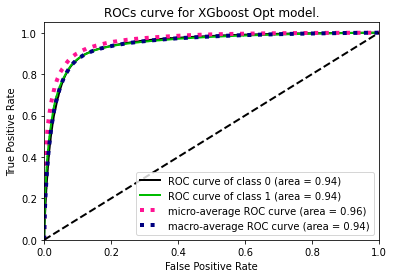

In [23]:
roc(xgboost_opt, 'XGboost Opt model')

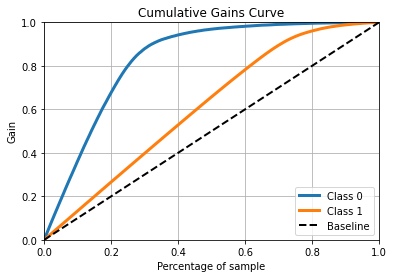

In [24]:
skplt.metrics.plot_cumulative_gain(Y_test, Y_proba);

Guardamos el modelo tuneado

In [25]:
model_t = '../modelos/xgboost_tune.sav'
pickle.dump(xgboost_opt, open(model_t, 'wb'))

## Conclusions

We have developed an update in our model by doing: 

+ Include the different pipelines in our saved models.

+ Plot both normalized confusion matrix and Cumulative Gains curve.

+ Include an enhanced XGBoost model, trying to achieve better results.

As we have seen in our different models we are achieving metrics upper to 90%. This lead us to think that maybe there could be a model-specification mistake which could give us false expectations. Anyway, we can discard overfitting due to we get similar results for both train and test samples. 

Moreover, checking the classification report of the models, we see that the precission is high for both classes, something that, at least, means thar our model is valid despite the high-accuracy we have achieved.

## References 

+ https://medium.com/@jboscomendoza/tutorial-xgboost-en-python-53e48fc58f73
+ https://xgboost.readthedocs.io/en/latest/python/python_api.html
+ https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e